<a href="https://colab.research.google.com/github/jiwon-min98/LearningPyTorch/blob/main/02_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Make classification data and get it ready

In [122]:
import sklearn

from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [123]:
print(f"First 5 sampels of X:\n{X[:5]}")
print(f"First 5 sampels of y:\n{y[:5]}")

First 5 sampels of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 sampels of y:
[1 1 1 1 0]


In [124]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


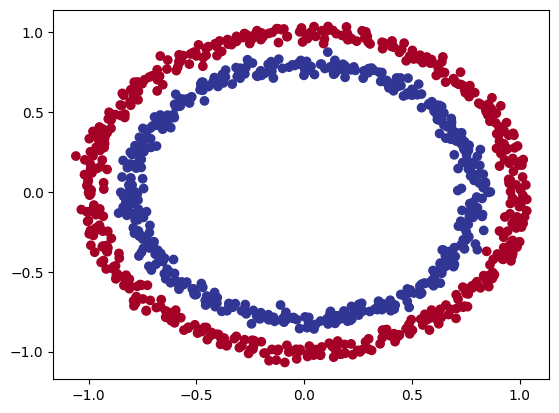

In [125]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [126]:
X.shape, y.shape

((1000, 2), (1000,))

In [127]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y:{y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y:{y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y:1
Shapes for one sample of X: (2,) and the same for y:()


### 1.2 Turn data into tensors and create train and test splits


In [128]:
import torch
torch.__version__

'2.0.1+cu118'

In [129]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [130]:
# Split data into training and test data
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [131]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training & testing loop

In [132]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [133]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that :
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling hte shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instanciate an instance of our model class and send it to the target `device`

In [134]:
# 1. model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. create 2 layers
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  # 3. defind a forward() method
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. instanciate an instance of our model class
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [135]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [136]:
# let's replicate the model using Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features =5),
    nn.Linear(in_features=5, out_features =1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [137]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2599, -0.4711],
                      [-0.4622, -0.0342],
                      [-0.2586, -0.5301],
                      [ 0.4194,  0.5686],
                      [ 0.1147, -0.1231]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6550, -0.2576,  0.1800,  0.3334, -0.0894], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1768,  0.2492, -0.3562,  0.2826, -0.1735]], device='cuda:0')),
             ('1.bias', tensor([0.0068], device='cuda:0'))])

In [138]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions:{len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples:{len(X_test)}, shape:{X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions:200, Shape:torch.Size([200, 1])
Length of test samples:200, shape:torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.3972],
        [ 0.5324],
        [-0.0570],
        [ 0.5263],
        [-0.2154],
        [-0.1317],
        [ 0.3746],
        [ 0.2186],
        [-0.0496],
        [ 0.5397]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function / optimizer should you use?

Again .. this is problem specific.
For example, for regression you might want MAE or MSE
For classification, you might want Binary cross entropy or categorical cross entropy.

In [139]:
# Setup the loss function
# BCELoss = requires inputs to have gone through the sigmoide activation function
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss - sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [140]:
# Calculate accuracy - out of 100 examples, what % does our model get right?
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc = correct/len(y_pred) *100
  return acc



## 3. Train model

To train our model, we need to build a train loop

1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward (backpropagation)
5. optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model ouputs are going to be raw **logits**
We can convert these **logits** into prediction probs by passing them to some kind of activation function (e.g. simoid for binary and soft max for muliclass classification)
Then we can convert our model's prediction probs to **prediction lables** by either rounding them or taking the `argmax()`

In [141]:
# View the first 5 outputs of the forward pass on the testdata
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.3972],
        [ 0.5324],
        [-0.0570],
        [ 0.5263],
        [-0.2154]], device='cuda:0')

In [142]:
# use the sigmoid activation function on our model logits to turn them into prediction probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5980],
        [0.6300],
        [0.4858],
        [0.6286],
        [0.4463]], device='cuda:0')

For our pred probs values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y=1
* `y_pred_probs` < 0.5, y=0

In [143]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze

tensor([True, True, True, True, True], device='cuda:0')


<function Tensor.squeeze>

### 3.2 Building a training and testing loop

In [144]:
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70197, Accuracy: 52.12% | Test loss: 0.71465, Test acc: 49.00%
Epoch: 10 | Loss: 0.69927, Accuracy: 51.62% | Test loss: 0.71020, Test acc: 47.50%
Epoch: 20 | Loss: 0.69778, Accuracy: 50.88% | Test loss: 0.70742, Test acc: 46.50%
Epoch: 30 | Loss: 0.69683, Accuracy: 51.00% | Test loss: 0.70548, Test acc: 46.00%
Epoch: 40 | Loss: 0.69616, Accuracy: 50.62% | Test loss: 0.70402, Test acc: 45.50%
Epoch: 50 | Loss: 0.69565, Accuracy: 50.88% | Test loss: 0.70286, Test acc: 45.00%
Epoch: 60 | Loss: 0.69525, Accuracy: 50.75% | Test loss: 0.70192, Test acc: 45.50%
Epoch: 70 | Loss: 0.69493, Accuracy: 50.50% | Test loss: 0.70113, Test acc: 46.00%
Epoch: 80 | Loss: 0.69467, Accuracy: 50.38% | Test loss: 0.70046, Test acc: 46.00%
Epoch: 90 | Loss: 0.69445, Accuracy: 50.38% | Test loss: 0.69989, Test acc: 46.00%


## 4. Make predictions and evaluate the model

From the metrics, it looks like out model isn't learning anything.
So let's make some predictions and make them visual to inspect them.

To do so, we're going to import a function called `plot_decision_boundary()`

In [145]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Download helper function")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper function


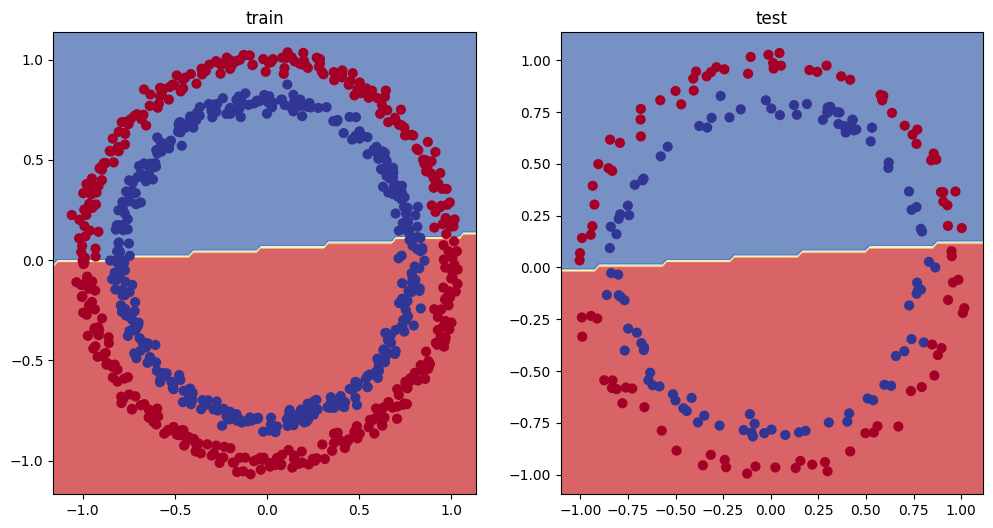

In [146]:
# Plot decision boundary of the mode
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model (from a model perspective)

* add more layers - give the model more chances to learn about patterns in the data
* add more hidden units - got from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly wiht the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change. they are refered to as **hyperparameters**


Let's try and improve our model by
* Adding more hidden units: 5->10
* Increase the number of layers 2->3
* Increase the number of epochs 100->1000

In [147]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [148]:
# Create a loss funciton
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [149]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### training
  model_1.train()

  # 1. forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate the loss/ accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. backpropagation
  loss.backward()

  # 5. optimizer step (gradient descent)
  optimizer.step()


  ### testing
  model_1.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  # Print out what's happening every 10 epochs
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


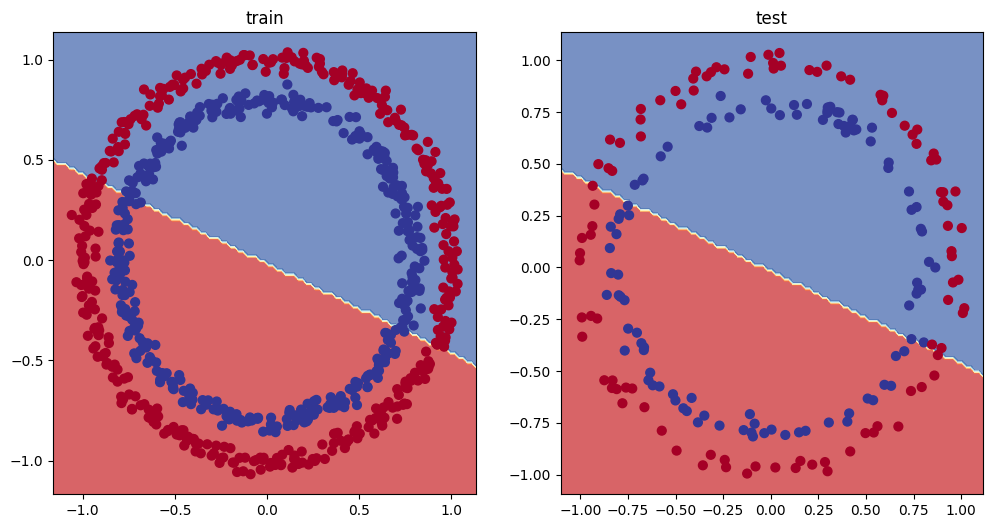

In [150]:
# Plot decision boundary of the mode
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_1,X_test,y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [151]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [152]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


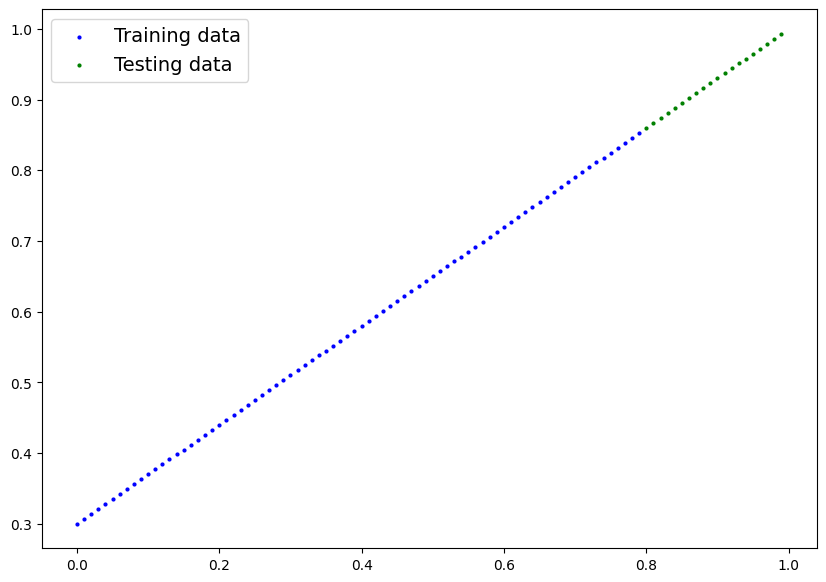

In [153]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

### 5.2 Adjusting `model_1` to fit a straight line

In [154]:
# same architecture as model_1 but using nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [155]:
# loss as optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [156]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# training
for epoch in range(epochs):
  y_pred=model_2(X_train_regression)
  loss=loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  # print
  if epoch % 100 ==0:
    print(f"Epoch: {epoch} | Loss :{loss:.5f}| Test loss :{test_loss:.5f}")


Epoch: 0 | Loss :0.75986| Test loss :0.54143
Epoch: 100 | Loss :0.09309| Test loss :0.02901
Epoch: 200 | Loss :0.07376| Test loss :0.02850
Epoch: 300 | Loss :0.06745| Test loss :0.00615
Epoch: 400 | Loss :0.06107| Test loss :0.02004
Epoch: 500 | Loss :0.05698| Test loss :0.01061
Epoch: 600 | Loss :0.04857| Test loss :0.01326
Epoch: 700 | Loss :0.06109| Test loss :0.02127
Epoch: 800 | Loss :0.05599| Test loss :0.01426
Epoch: 900 | Loss :0.05571| Test loss :0.00603


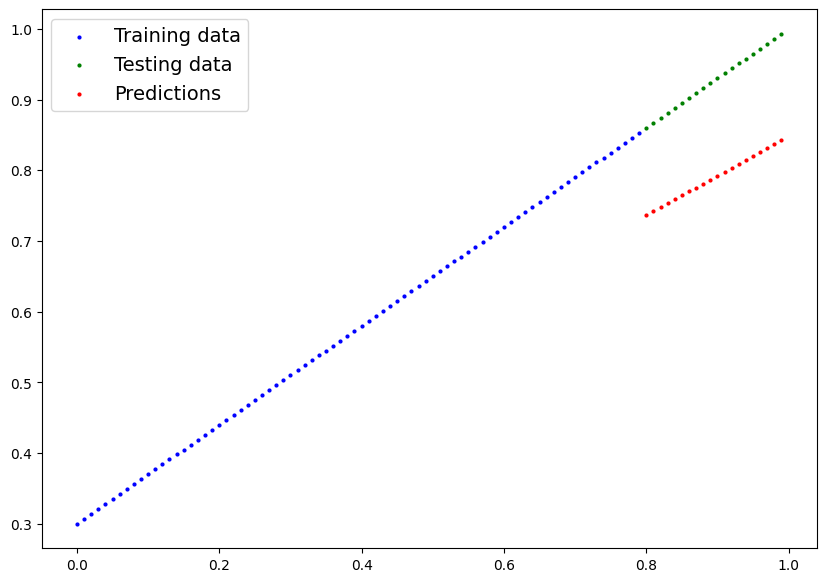

In [157]:
# turn on eval mode
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions = y_preds.cpu())

## 6. The missing piece : non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

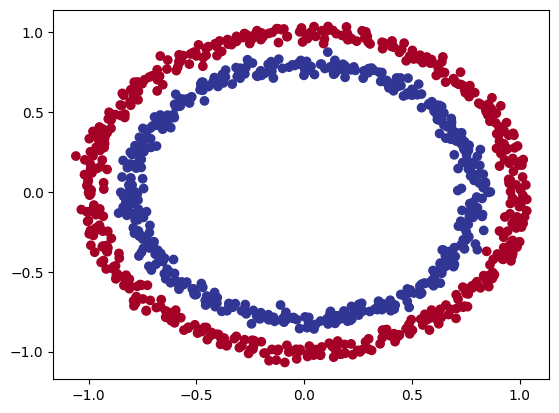

In [158]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap= plt.cm.RdYlBu)

In [159]:
# Convert data to tensors and then to trainand test split
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


### 6.2 Building a model with non-linearity

In [160]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2, out_features=10)
    self.layer_2=nn.Linear(in_features=10, out_features=10)
    self.layer_3=nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # non-linear activation function

  def forward(self,x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [161]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr= 0.1)

### 6.3 Training model with non-linearity

In [162]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ## training
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss= loss_fn(test_logits, y_test)
    test_acc=accuracy_fn(y_true=y_test, y_pred=test_pred)

  #print
  if epoch % 100 ==0:
    print(f"Epoch: {epoch}| Loss: {loss:.4f}, Acc: {acc: .2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc: .2f}%")

Epoch: 0| Loss: 0.6929, Acc:  50.00% | Test Loss: 0.6932, Test Acc:  50.00%
Epoch: 100| Loss: 0.6912, Acc:  52.88% | Test Loss: 0.6910, Test Acc:  52.50%
Epoch: 200| Loss: 0.6898, Acc:  53.37% | Test Loss: 0.6894, Test Acc:  55.00%
Epoch: 300| Loss: 0.6879, Acc:  53.00% | Test Loss: 0.6872, Test Acc:  56.00%
Epoch: 400| Loss: 0.6852, Acc:  52.75% | Test Loss: 0.6841, Test Acc:  56.50%
Epoch: 500| Loss: 0.6810, Acc:  52.75% | Test Loss: 0.6794, Test Acc:  56.50%
Epoch: 600| Loss: 0.6751, Acc:  54.50% | Test Loss: 0.6729, Test Acc:  56.00%
Epoch: 700| Loss: 0.6666, Acc:  58.38% | Test Loss: 0.6632, Test Acc:  59.00%
Epoch: 800| Loss: 0.6516, Acc:  64.00% | Test Loss: 0.6476, Test Acc:  67.50%
Epoch: 900| Loss: 0.6236, Acc:  74.00% | Test Loss: 0.6215, Test Acc:  79.00%


### 6.4 evaluating a model trained with non-linear activation functions

In [163]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

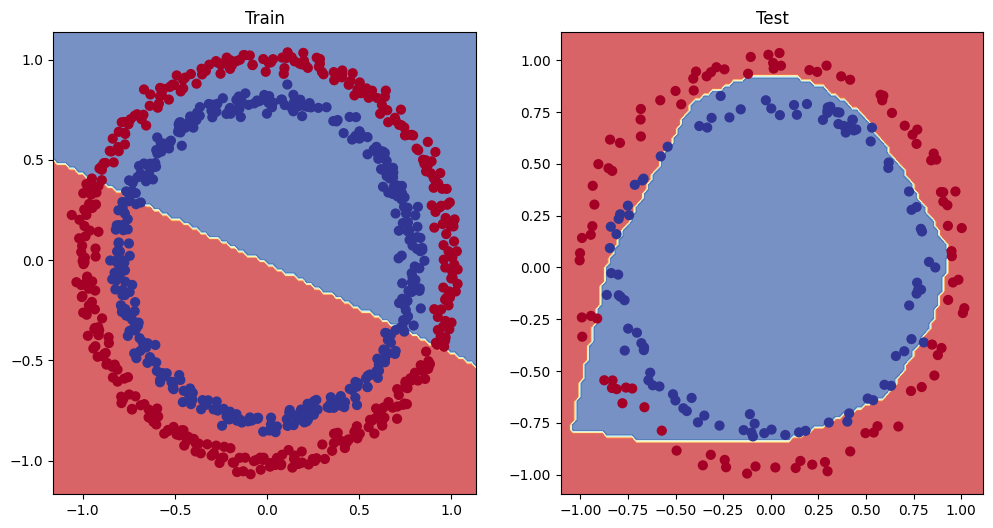

In [164]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) #has non-linearity


## 7. Replicatiing non-linear activation functions

NN, ratherthan us telling the model what to learn, we git it the tools to discover patterns in ata and it tries to figure out the patterns on its one

In [165]:
# Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

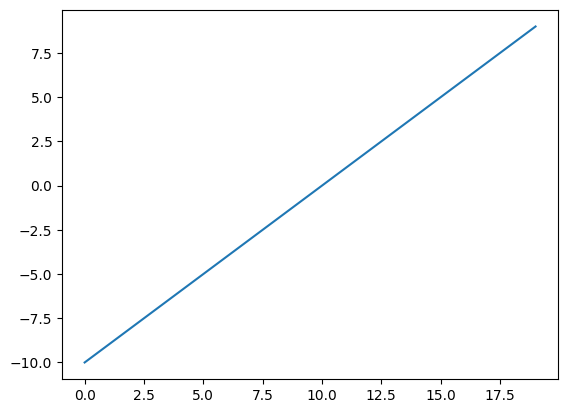

In [166]:
# Visualize the tensor
plt.plot(A)

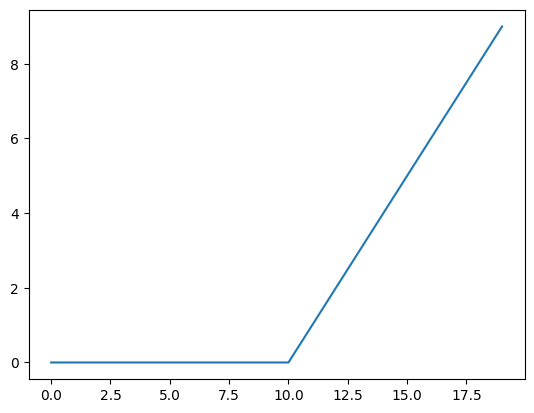

In [167]:
plt.plot(torch.relu(A))

In [168]:
def relu(x: torch.Tensor)->torch.Tensor:
  return torch.max(torch.tensor(0),x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [169]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

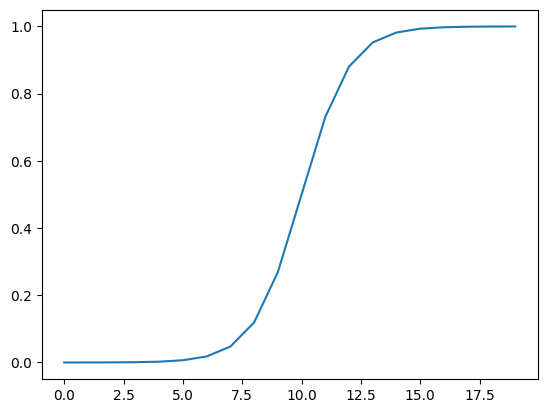

In [170]:
plt.plot(torch.sigmoid(A))

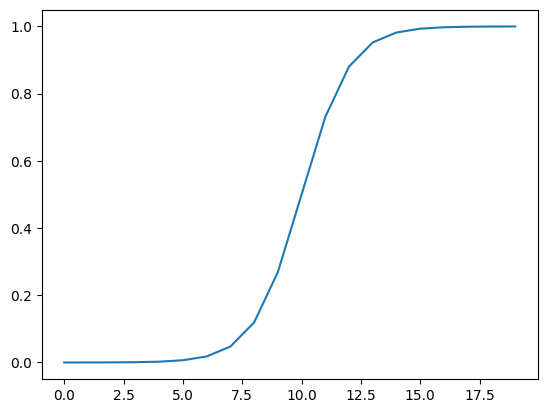

In [171]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

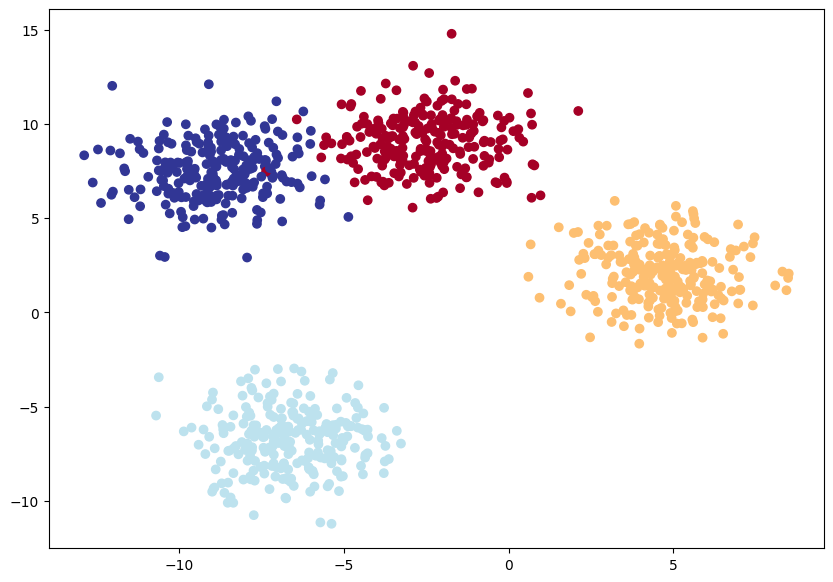

In [185]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, #give the clusters a littels shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [186]:
# Create device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [215]:
# Build a multi-class classifcation model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of OUTput features to the model
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features =2,
                    output_features=4,
                    hidden_units=8).to(device)


In [216]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [217]:
 torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [218]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probs for multi-class PyTorch model

In [219]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [220]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [221]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [222]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [223]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

  #print
  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}%| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1588, Acc: 40.38%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 10 | Loss: 0.6448, Acc: 96.75%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 30 | Loss: 0.2529, Acc: 99.12%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25%| Test Loss: 0.5744, Test Acc: 86.50%


### 8.6 making and evaluating predictions with a PyTorch multiclass model

In [224]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [225]:
# go from logits -> prediction probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [226]:
# go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

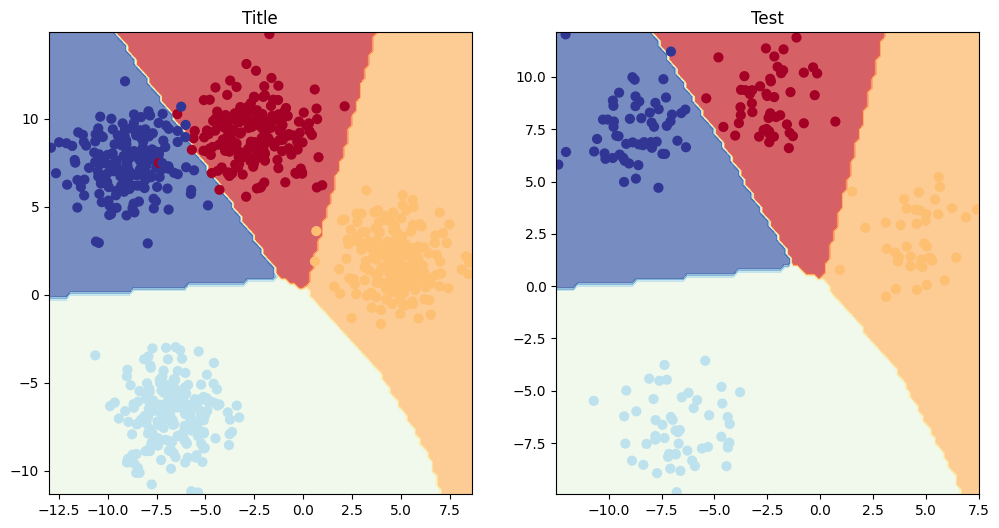

In [227]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Title")
plot_decision_boundary(model_4, X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test,y_blob_test)

## 9. A few more classification metrics

* Accuracy - out of 100 samples, how many does our model get right
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report